# Nowcasting CPI
geoff pidcock | PacifImpact | Sept 2020

## Scope
- Setup
- Review current CPI measures, and expert opinions on their movement (for evaluation purposes)
- Attempt to nowcast using the existing `Port Calls` product (produced by the [AIS Task Team](https://comtrade.un.org/data/cache/AISdashboardMethodology.pdf)
- Attempt to nowcast using novel AIS data products

In [37]:
# Setup
import os
from dotenv import load_dotenv, find_dotenv

# find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()

# load up the entries as environment variables
load_dotenv(dotenv_path)

DBUNAME = os.environ.get("DBUNAME")
DBPASSWORD = os.environ.get("DBPASSWORD")
DBHOST = os.environ.get("DBHOST")
DBPORT = os.environ.get("DBPORT")
DBNAME = os.environ.get("DBNAME")

import sqlalchemy
import psycopg2

connection_str = 'postgresql+psycopg2://'+DBUNAME+':'+DBPASSWORD+'@'+DBHOST+':'+DBPORT+'/'+DBNAME

In [38]:
%matplotlib inline
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pickle
from matplotlib import rcParams

In [39]:
try:
    engine = sqlalchemy.create_engine(connection_str)
    conn = engine.connect()
except:
    print('Database connection error - check creds')

### one time upload of port call data to postgres

In [4]:
# one time upload of port call data to postgres
data_port = pd.read_csv('../data/raw/daily_port_calls.csv')
data_port_prep = data_port.loc[
    data_port['GID_0'].isin(['FJI','VUT','KIR','COK','SLB','PLW'])
    ,['date-entry','GID_0','port-name','port_calls']
].copy()
data_port_prep.GID_0.value_counts()

FJI    896
SLB    472
VUT    243
KIR    100
PLW     92
COK     39
Name: GID_0, dtype: int64

In [13]:
country_map = {
    'FJI':'fj'
    ,'SLB':'sb'
    ,'COK':'ck'
    ,'PLW':'pw'
    ,'VUT':'vu'
    ,'KIR':'ki'
}

region_map = {
    'FJI':'melanesia'
    ,'SLB':'melanesia'
    ,'COK':'polynesia'
    ,'PLW':'micronesia'
    ,'VUT':'melanesia'
    ,'KIR':'polynesia'
}

data_port_prep['country'] = data_port_prep.GID_0.apply(lambda x: country_map.get(x))
data_port_prep['region'] = data_port_prep.GID_0.apply(lambda x: region_map.get(x))
data_port_prep['date-entry'] = pd.to_datetime(data_port_prep['date-entry']
                                             ,format='%m/%d/%Y')
data_port_prep['key'] = data_port_prep['country']+'--'+data_port_prep['port-name']+'--'+\
data_port_prep['date-entry'].astype(str)

data_port_prep.head()

,date-entry,GID_0,port-name,port_calls,country,region,key
11,2020-08-21,FJI,Lautoka Harbor,1,fj,melanesia,fj--Lautoka Harbor--2020-08-21
609,2020-08-21,SLB,Honiara,0,sb,melanesia,sb--Honiara--2020-08-21
610,2020-08-21,SLB,Honiara,1,sb,melanesia,sb--Honiara--2020-08-21
747,2020-08-22,SLB,Port Noro,4,sb,melanesia,sb--Port Noro--2020-08-22
2141,2020-08-21,FJI,Suva Harbor,0,fj,melanesia,fj--Suva Harbor--2020-08-21


In [7]:
# confirm tables are present as expected
engine.table_names() 

['test', 'test2', 'stg_country_metrics', 'country_metrics', 'stg_ais']

In [14]:
data_port_prep[['key','region','country','port-name','date-entry','port_calls']]\
.to_sql('ais_port_calls'
        ,con = engine
        ,if_exists='replace'
        ,index=False
        ,method='multi')

In [15]:
pd.read_sql("select * from public.ais_port_calls limit 5",con=engine)

,key,region,country,port-name,date-entry,port_calls
0,fj--Lautoka Harbor--2020-08-21,melanesia,fj,Lautoka Harbor,2020-08-21,1
1,sb--Honiara--2020-08-21,melanesia,sb,Honiara,2020-08-21,0
2,sb--Honiara--2020-08-21,melanesia,sb,Honiara,2020-08-21,1
3,sb--Port Noro--2020-08-22,melanesia,sb,Port Noro,2020-08-22,4
4,fj--Suva Harbor--2020-08-21,melanesia,fj,Suva Harbor,2020-08-21,0


# Review current CPI numbers

In [16]:
pd.read_sql(
"""
select name, country, frequency, min(date), max(date)
from public.country_metrics
where true
and category = 'CPI'
-- and country in ('fj','vu','ck','ki','pw','sb','PW','kir')
group by 1,2,3
order by 1,2,3

"""
,con=engine
)

,name,country,frequency,min,max
0,CPI_2006_ALCOHOL/TOBACCO,kir,monthly,2018-01-01,2019-12-01
1,CPI_2006_ALL ITEMS,kir,monthly,2018-01-01,2019-12-01
2,CPI_2006_CLOTHING,kir,monthly,2018-01-01,2019-12-01
3,CPI_2006_EDUCATION & HEALTH,kir,monthly,2018-01-01,2019-12-01
4,CPI_2006_FOOD,kir,monthly,2018-01-01,2019-12-01
5,CPI_2006_HOUSEHOLD OPERATION,kir,monthly,2018-01-01,2019-12-01
6,CPI_2006_HOUSING,kir,monthly,2018-01-01,2019-12-01
7,CPI_2006_NON-ALCOHOLIC DRINKS,kir,monthly,2018-01-01,2019-12-01
8,CPI_2006_RECREATION,kir,monthly,2018-01-01,2019-12-01
9,CPI_2006_TRANSPORTATION,kir,monthly,2018-01-01,2019-12-01


In [30]:
# todo - figure out how to handle quarterly (down-sample through averaging?)
# potentially look at F&B -- ethel suspected it would correlate well.
data_cpi = pd.read_sql("""
with model as (
    select
        case 
            when country in ('fj','vn','sb') then 'melanesia'
            when country in ('ck','kir') then 'polynesia'
            when country in ('PW','pw','pl') then 'micronesia'
         end as region
        ,case when country = 'kir' then 'ki'
            else lower(country) end as country    
        ,case
            when lower(country) = 'fj' then to_date(date,'YYYY-MM')
            else to_date(date,'YYYY-MM-DD')
         end as date
        ,case
            when lower(country) = 'fj' and name = 'CPI_2014_Total' then cast(value as float)
            when lower(country) = 'pw' and name = 'CPI_2016_Total' then cast(value as float)
            when lower(country) = 'kir' and name = 'CPI_2006_ALL ITEMS' then cast(value as float)
            when lower(country) = 'sb' and name = 'CPI_2017_Total' then cast(value as float)
            else 0 end as cpi_total
    from public.country_metrics
    where true
        and lower(category) = 'cpi'
        and frequency = 'monthly'
        and lower(country) in ('fj','vn','ck','kir','pw','pl','sb')
--        and date between '2019-01-01' and '2019-12-01'    
)
select 
    region
    ,country
    ,date
    ,sum(cpi_total) as cpi_total
from model 
group by 1,2,3
order by 1,2,3
;;

""",con=engine)
data_cpi

,region,country,date,cpi_total
0,melanesia,fj,2018-01-01,110.4
1,melanesia,fj,2018-02-01,111.1
2,melanesia,fj,2018-03-01,111.6
3,melanesia,fj,2018-04-01,113.5
4,melanesia,fj,2018-05-01,114.0
...,...,...,...,...
74,polynesia,ki,2019-08-01,125.0
75,polynesia,ki,2019-09-01,125.2
76,polynesia,ki,2019-10-01,125.4
77,polynesia,ki,2019-11-01,125.4


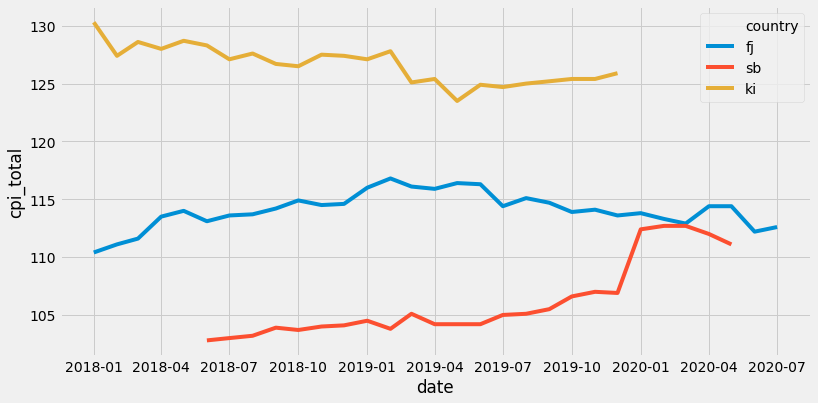

In [32]:
import matplotlib.style as style
import seaborn as sns
style.use('fivethirtyeight')
plt.clf
f = plt.figure(figsize=(12,6))
sns.lineplot(x='date',y='cpi_total',hue='country', data=data_cpi)
plt.show()

# Review current Trade Numbers

In [40]:
# analytics query
data_trade2 = pd.read_sql(
"""
        with model as (
            select
                date
                ,case 
                    when country in ('fj','vn','sb') then 'melanesia'
                    when country in ('ck','ki') then 'polynesia'
                    when country in ('pw','pl') then 'micronesia'
                 end as region
                ,case when country = 'pl' then 'pw'
                     when country = 'vn' then 'vu'
                     else country end as country
                ,case 
                    when (country = 'vn' and name='total-imports') then 1000000*cast(value as float)
                    when (country = 'pl' and name='imports-cif') then cast(value as float)
                    when (country not in ('pl','vn') and name='imports-cif') then 1000*cast(value as float)
                    else 0 
                 end as trade_imports
                ,case 
                    when (country = 'vn' and name='total-exports') then 1000000*cast(value as float)
                    when (country = 'pl' and name='exports-fob-total') then cast(value as float)
                    when (country not in ('pl','vn') and name='exports-fob-total') then 1000*cast(value as float)
                    else 0 
                 end as trade_exports
            from public.country_metrics
            where true
                and category = 'trade'
                and frequency = 'monthly'
                and country in ('fj','vn','ck','ki','pw','pl','sb')
                and date between '2019-01-01' and '2020-07-31'
        )
        select 
            region
            ,country
            ,date            
            ,sum(trade_imports) as trade_imports
            ,sum(trade_exports) as trade_exports
            ,sum(trade_imports) + sum(trade_exports) as trade_volume
            ,sum(trade_exports) - sum(trade_imports) as trade_balance
            ,sum(trade_exports)/sum(trade_imports) as export_import_ratio
        from model   
        group by 1,2,3
        order by 1,2,3   
"""
,con=engine,parse_dates='date')
data_trade2

,region,country,date,trade_imports,trade_exports,trade_volume,trade_balance,export_import_ratio
0,melanesia,fj,2019-01-01,6.030260e+08,2.091587e+08,8.121847e+08,-3.938673e+08,0.346849
1,melanesia,fj,2019-02-01,3.612810e+08,1.602607e+08,5.215417e+08,-2.010203e+08,0.443590
2,melanesia,fj,2019-03-01,3.864050e+08,1.682713e+08,5.546763e+08,-2.181337e+08,0.435479
3,melanesia,fj,2019-04-01,4.271140e+08,1.666927e+08,5.938067e+08,-2.604213e+08,0.390277
4,melanesia,fj,2019-05-01,4.626890e+08,1.790928e+08,6.417818e+08,-2.835962e+08,0.387069
...,...,...,...,...,...,...,...,...
67,polynesia,ki,2019-08-01,1.564470e+07,2.192664e+06,1.783737e+07,-1.345204e+07,0.140154
68,polynesia,ki,2019-09-01,1.484654e+07,1.375781e+06,1.622232e+07,-1.347076e+07,0.092667
69,polynesia,ki,2019-10-01,1.619253e+07,7.567212e+05,1.694925e+07,-1.543581e+07,0.046733
70,polynesia,ki,2019-11-01,1.269483e+07,1.412641e+06,1.410747e+07,-1.128219e+07,0.111277


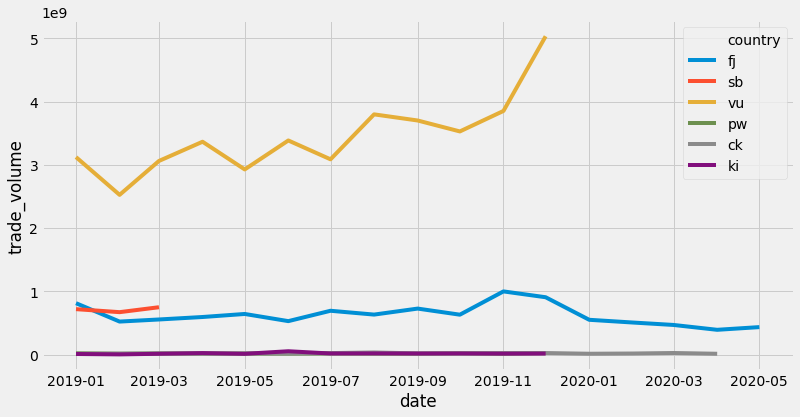

In [42]:
import matplotlib.style as style
import seaborn as sns
style.use('fivethirtyeight')
plt.clf
f = plt.figure(figsize=(12,6))
sns.lineplot(x='date',y='trade_volume',hue='country', data=data_trade2)
plt.show()

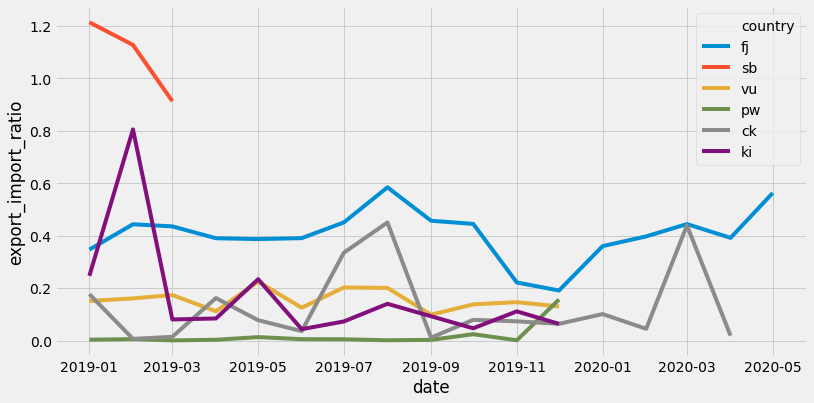

In [43]:
import matplotlib.style as style
import seaborn as sns
style.use('fivethirtyeight')
plt.clf
f = plt.figure(figsize=(12,6))
sns.lineplot(x='date',y='export_import_ratio',hue='country', data=data_trade2)
plt.show()

# Review GDP Numbers

- These numbers are typically only yearly
- There may be poor coverage between our numbers and these ones

In [45]:
pd.read_sql("""
select
    country
    ,min(date)    
    ,max(date)
from public.country_metrics
where category = 'trade'
group by 1
""",con=engine)

,country,min,max
0,pl,2018-01-01,2019-12-01
1,ki,2016-01-01,2019-12-01
2,sb,2018-01-01,2019-03-01
3,ws,1/01/2018,1/12/2019
4,fj,2014-01-01,2020-05-01
5,vn,2016-12-01,2019-12-01
6,ck,2017-01-01,2020-04-01


In [46]:
pd.read_sql("""
select distinct category from public.country_metrics
""",con=engine)

,category
0,trade
1,CPI
2,GDP
3,tourism


In [47]:
pd.read_sql("""
select
    country
    ,min(date)    
    ,max(date)
from public.country_metrics
where category = 'tourism'
group by 1
""",con=engine)

,country,min,max
0,pl,2007-06-01,2020-01-01
1,sb,2016-01-01 00:00:00,2020-01-01 00:00:00
2,fj,2018-01-01 00:00:00,2020-06-01 00:00:00
3,vn,2015-03-01,2020-03-01
4,ck,2018-01-01 00:00:00,2020-03-01 00:00:00


In [48]:
pd.read_sql("""
select
    country
    ,min(date)    
    ,max(date)
from public.country_metrics
where category = 'CPI'
group by 1
""",con=engine)

,country,min,max
0,sb,2018-06-01,2020-05-01
1,kir,2018-01-01,2019-12-01
2,fj,2018-01,2020-07
3,PW,2018-03-01,2020-03-01


In [49]:
pd.read_sql("""
select
    country
    ,min(date)    
    ,max(date)
from public.country_metrics
where category = 'GDP'
group by 1
""",con=engine)

,country,min,max
0,wsm,Dec-17,Sep-19
1,ck,Dec-17,Sep-19


In [50]:
pd.read_sql("""
select *
from public.country_metrics
where category = 'GDP'
""",con=engine)

,metric_key,frequency,country,category,source,name,date,value,properties
0,GDP_Agriculture_Dec-17,quartely,wsm,GDP,Samoa_Bureau_Statistics,GDP_Agriculture,Dec-17,37.6,{currency = tala}
1,GDP_Agriculture_Mar-18,quartely,wsm,GDP,Samoa_Bureau_Statistics,GDP_Agriculture,Mar-18,40.1,{currency = tala}
2,GDP_Agriculture_Jun-18,quartely,wsm,GDP,Samoa_Bureau_Statistics,GDP_Agriculture,Jun-18,33.4,{currency = tala}
3,GDP_Agriculture_Sep-18,quartely,wsm,GDP,Samoa_Bureau_Statistics,GDP_Agriculture,Sep-18,38.1,{currency = tala}
4,GDP_Agriculture_Dec-18,quartely,wsm,GDP,Samoa_Bureau_Statistics,GDP_Agriculture,Dec-18,44.2,{currency = tala}
...,...,...,...,...,...,...,...,...,...
443,GDP_Education_Mar-20,quartely,ck,GDP,National_stat_ck,GDP_Education,Mar-20,2.8,{currency = nzd}
444,GDP_Human Health and Social Work_Mar-20,quartely,ck,GDP,National_stat_ck,GDP_Human Health and Social Work,Mar-20,2.5,{currency = nzd}
445,"GDP_Arts, Recreation, Other Services_Mar-20",quartely,ck,GDP,National_stat_ck,"GDP_Arts, Recreation, Other Services",Mar-20,0.9,{currency = nzd}
446,GDP_Taxes on Products_Mar-20,quartely,ck,GDP,National_stat_ck,GDP_Taxes on Products,Mar-20,24.7,{currency = nzd}


# Attempt to Nowcast using Port Calls
For the following regions 
- Melanesia: Fiji, Vanuatu
- Polynesia: Kiribati, Cook Islands
- Micronesia: Palau

Target
- CPI
- Trade Volume (imports + exports)

Feature gaps
- Trade - None
- Tourism - VU, KI, PW

In [19]:
pd.read_sql("select distinct country, name from public.country_metrics where category = 'trade' order by 1",con=engine)

,country,name
0,ck,exports-fob-reexport
1,ck,exports-fob-total
2,ck,trade-balance
3,ck,imports-cif
4,ck,exports-fob-domestic
5,fj,imports-cif
6,fj,exports-fob-domestic
7,fj,trade-balance
8,fj,exports-fob-reexport
9,fj,exports-fob-total
